# (Generalized) Linear and Hierarchical Linear Models in PyMC3

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import statsmodels.api as sm
import theano

from pandas.plotting import scatter_matrix
from pymc3 import *
from statsmodels.formula.api import glm as glm_sm
from numpy.random import default_rng

print(f"Running on PyMC3 v{pm.__version__}")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.11.2


In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng=default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Linear Regression

Lets generate some data with known slope and intercept and fit a simple linear GLM.

In [3]:
size = 50
true_intercept = 1
true_slope = 2
x = np.linspace(0, 1, size)
y = true_intercept + x * true_slope + rng.normal(scale=0.5, size=size)
data = {"x": x, "y": y}

The `glm.linear_component()` function can be used to generate the output variable y_est and coefficients of the specified linear model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
/home/kavya/.local/lib/python3.8/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


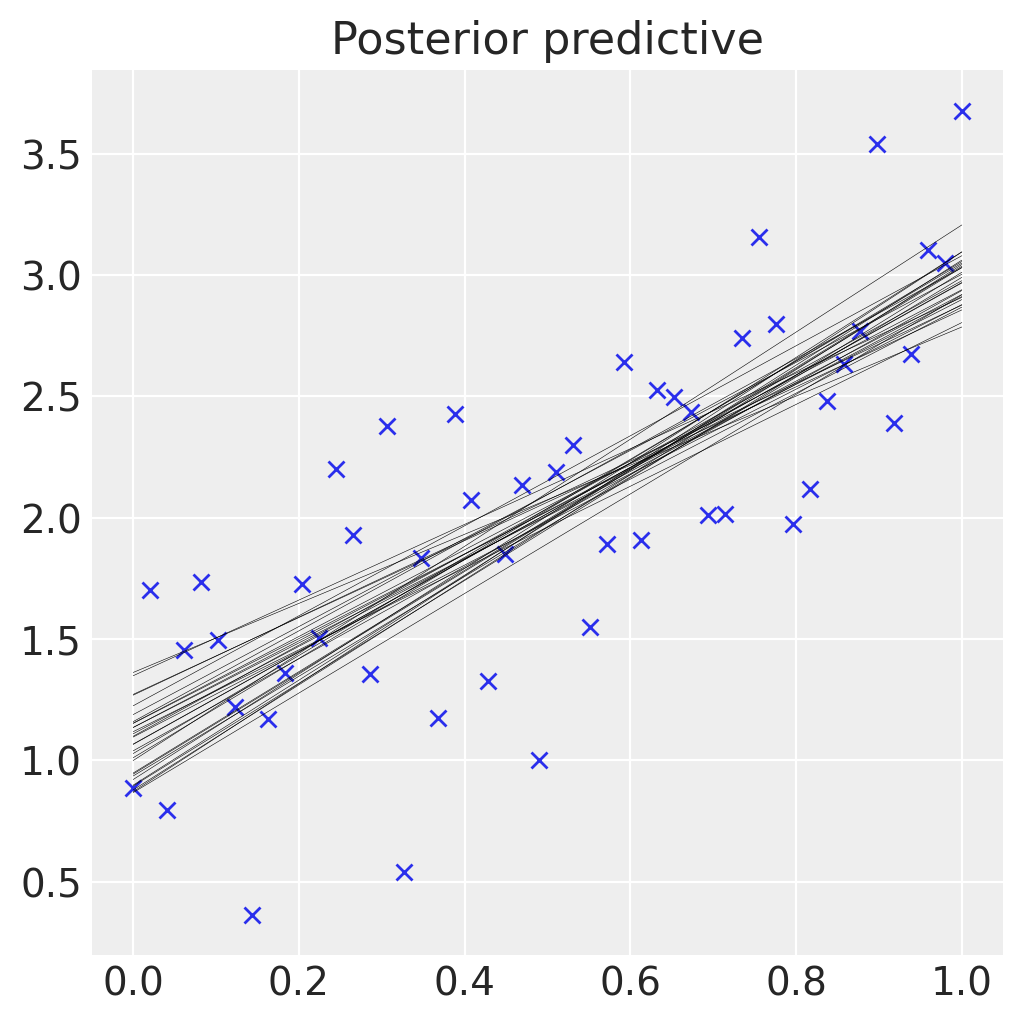

In [4]:
with Model() as model:
    lm = glm.LinearComponent.from_formula("y ~ x", data)
    sigma = Uniform("sigma", 0, 20)
    y_obs = Normal("y_obs", mu=lm.y_est, sigma=sigma, observed=y)
    trace=pm.sample(2000, cores =2, return_inferencedata=True)

plt.figure(figsize=(5, 5))
plt.plot(x, y, "x")
plot_posterior_predictive_glm(trace)

Since there are a couple of general linear models that are being used over and over again (Normally distributed noise, logistic regression etc), the `glm.glm()` function simplifies the above step by creating the likelihood (y_obs) and its priors (sigma) for us. Since we are working in the model context, the random variables are all added to the model behind the scenes. This function also automatically finds a good starting point which it returns.

Note that the below call to `glm()` is producing exactly the same model as above, just more succinctly.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
/home/kavya/.local/lib/python3.8/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


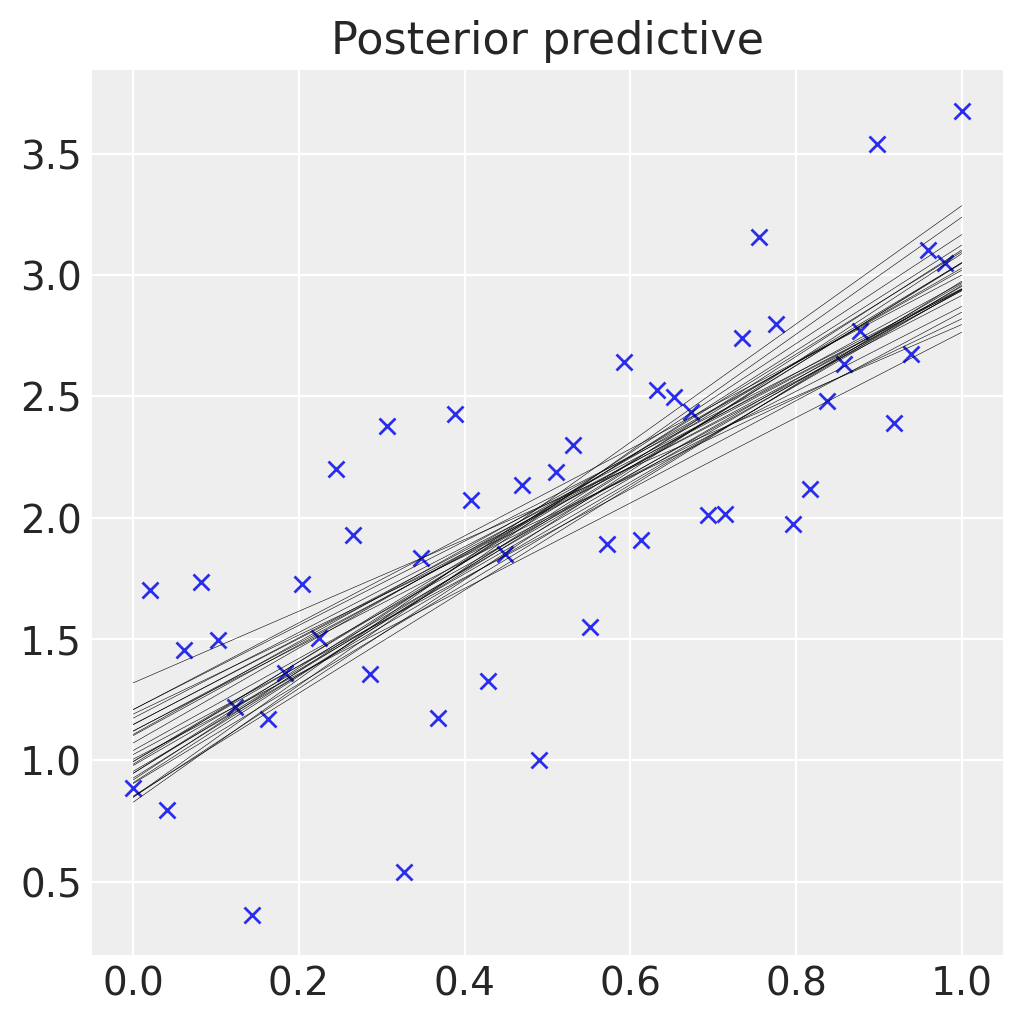

In [5]:
with Model() as model:
    GLM.from_formula("y ~ x", data)
    trace=pm.sample(2000, cores =2, return_inferencedata=True)

plt.figure(figsize=(5, 5))
plt.plot(x, y, "x")
plot_posterior_predictive_glm(trace)

## Robust GLM

Lets try the same model but with a few outliers in the data.

In [6]:
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])
data_outlier = dict(x=x_out, y=y_out)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
/home/kavya/.local/lib/python3.8/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


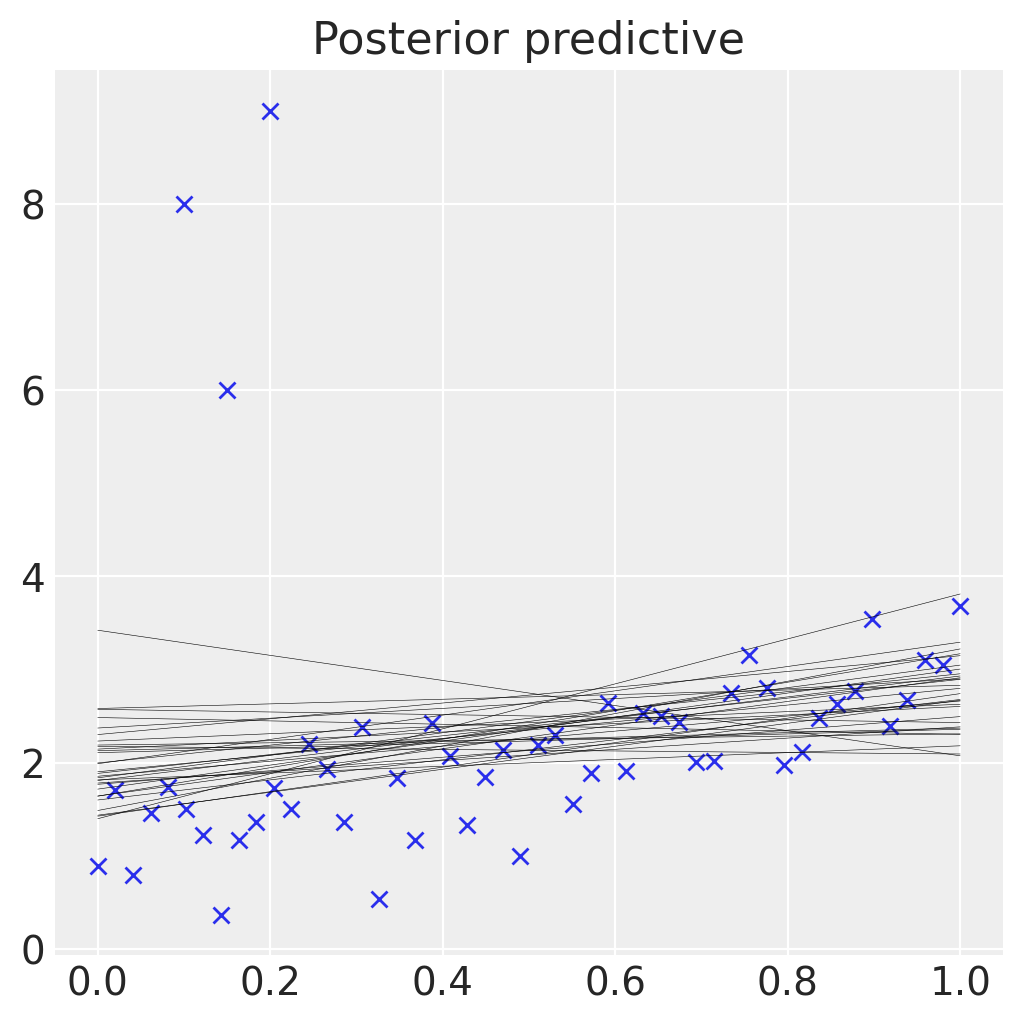

In [7]:
with Model() as model:
    GLM.from_formula("y ~ x", data_outlier)
    trace=pm.sample(2000, cores =2, return_inferencedata=True)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, "x")
plot_posterior_predictive_glm(trace)

Because the normal distribution does not have a lot of mass in the tails, an outlier will affect the fit strongly.

Instead, we can replace the Normal likelihood with a student T distribution which has heavier tails and is more robust towards outliers. While this could be done with the `linear_compoment()` function and manually defining the T likelihood we can use the `glm()` function for more automation. By default this function uses a normal likelihood. To define the usage of a T distribution instead we can pass a family object that contains information on how to link the output to `y_est` (in this case we explicitly use the Identity link function which is also the default) and what the priors for the T distribution are. Here we fix the degrees of freedom `nu` to 1.5.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
/home/kavya/.local/lib/python3.8/site-packages/pymc3/plots/posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


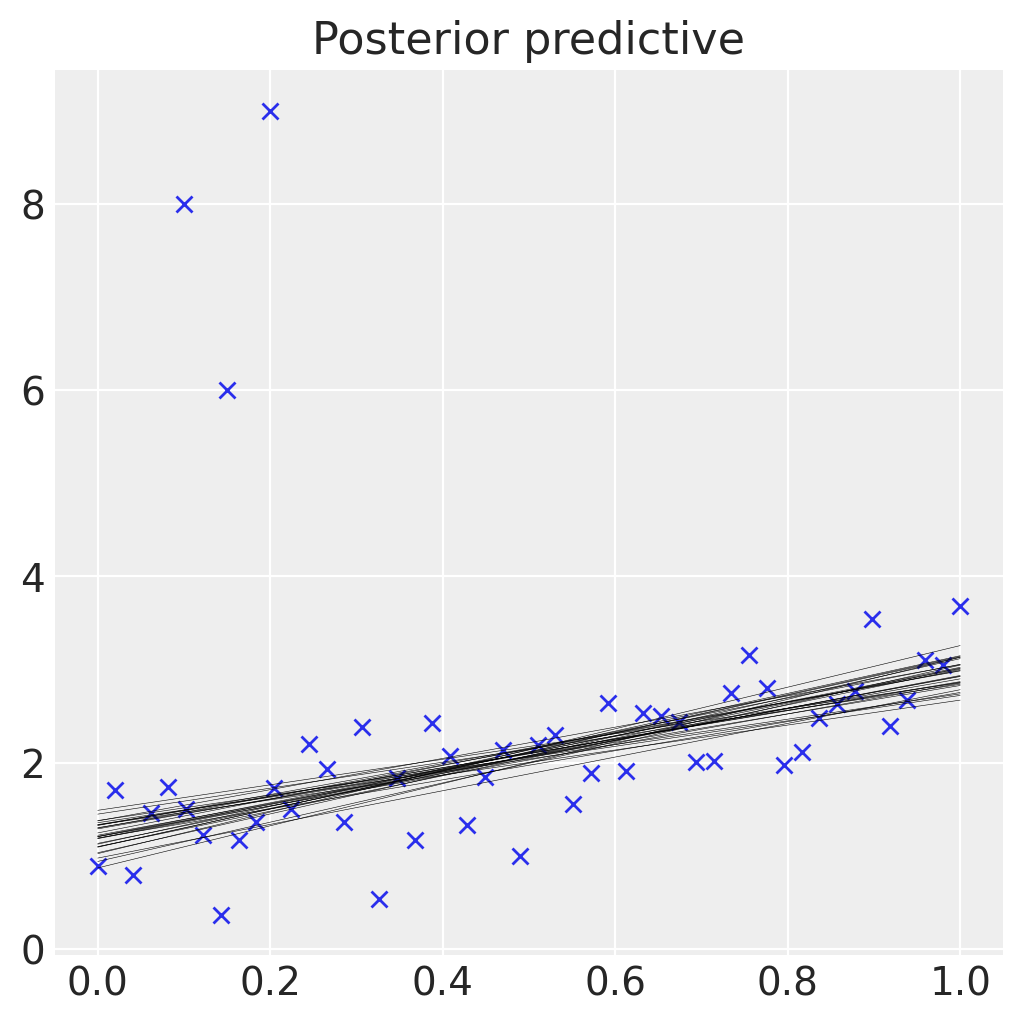

In [8]:
with Model() as model_robust:
    family = glm.families.StudentT(
        link=glm.families.Identity(), priors={"nu": 1.5, "lam": Uniform.dist(0, 20)}
    )
    GLM.from_formula("y ~ x", data_outlier, family=family)
    trace=pm.sample(2000, cores =2, return_inferencedata=True)

plt.figure(figsize=(5, 5))
plt.plot(x_out, y_out, "x")
plot_posterior_predictive_glm(trace)


## Hierarchical GLM

In [9]:
#This try except clause will ensure that users who have cloned pymc-examples repo will read their local copy of the data while also downloading the data from github for those who don't have a local copy.
try:
    sat_data = pd.read_csv("../data/Guber1999data.txt")
except:
    sat_data = pd.read_csv(pm.get_data("Guber1999data.txt"))

In [10]:
with Model() as model_sat:
    grp_mean = Normal("grp_mean", mu=0, sigma=10)
    grp_sd = Uniform("grp_sd", 0, 200)
    # Define priors for intercept and regression coefficients.
    priors = {
        "Intercept": Normal.dist(mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std()),
        "spend": Normal.dist(mu=grp_mean, sigma=grp_sd),
        "stu_tea_rat": Normal.dist(mu=grp_mean, sigma=grp_sd),
        "salary": Normal.dist(mu=grp_mean, sigma=grp_sd),
        "prcnt_take": Normal.dist(mu=grp_mean, sigma=grp_sd),
    }
    GLM.from_formula("sat_t ~ spend + stu_tea_rat + salary + prcnt_take", sat_data, priors=priors)
    trace_sat = sample(2000, cores=2)

MissingInputError: Input 0 of the graph (indices start from 0), used to compute sigmoid(grp_sd_interval__), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [11]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12, 12));

NameError: name 'trace_sat' is not defined

In [12]:
with Model() as model_sat:
    grp_mean = Normal("grp_mean", mu=0, sigma=10)
    grp_prec = Gamma("grp_prec", alpha=1, beta=0.1, testval=1.0)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std())
    GLM.from_formula(
        "sat_t ~ spend + stu_tea_rat + salary + prcnt_take",
        sat_data,
        priors={"Intercept": intercept, "Regressor": slope},
    )
    trace_sat = sample(2000, cores=2)

MissingInputError: Input 1 of the graph (indices start from 0), used to compute Elemwise{sub,no_inplace}(spend, grp_mean), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [13]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12, 12));

NameError: name 'trace_sat' is not defined

In [14]:
tdf_gain = 5.0
with Model() as model_sat:
    grp_mean = Normal("grp_mean", mu=0, sigma=10)
    grp_prec = Gamma("grp_prec", alpha=1, beta=0.1, testval=1.0)
    slope = StudentT.dist(mu=grp_mean, lam=grp_prec, nu=1)  # grp_df)
    intercept = Normal.dist(mu=sat_data.sat_t.mean(), sigma=sat_data.sat_t.std())
    GLM.from_formula(
        "sat_t ~ spend + stu_tea_rat + salary + prcnt_take",
        sat_data,
        priors={"Intercept": intercept, "Regressor": slope},
    )

    trace_sat = sample(2000, cores=2)

MissingInputError: Input 1 of the graph (indices start from 0), used to compute Elemwise{sub,no_inplace}(spend, grp_mean), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [15]:
scatter_matrix(trace_to_dataframe(trace_sat), figsize=(12, 12));

NameError: name 'trace_sat' is not defined

## Logistic Regression

In [16]:
htwt_data = pd.read_csv(get_data("HtWt.csv"))
htwt_data.head()

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6


In [17]:
m = glm_sm("male ~ height + weight", htwt_data, family=sm.families.Binomial()).fit()
print(m.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   male   No. Observations:                   70
Model:                            GLM   Df Residuals:                       67
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.298
Date:                Sun, 02 May 2021   Deviance:                       56.597
Time:                        16:41:03   Pearson chi2:                     62.8
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -45.2059     10.887     -4.152      0.0

In [18]:
with Model() as model_htwt:
    GLM.from_formula("male ~ height + weight", htwt_data, family=glm.families.Binomial())
    trace_htwt = sample(
        2000, cores=2, init="adapt_diag"
    )  # default init with jitter can cause problem

<ipython-input-18-749820877528>:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_htwt = sample(
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [weight, height, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 30 seconds.
The number of effective samples is smaller than 25% for some parameters.


/home/kavya/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:42: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=0, hspace=0)


                mean        std         min        25%        50%        75%  \
Intercept -49.704145  11.415478 -102.870971 -56.872629 -48.719037 -41.265994   
height      0.722620   0.172961    0.335202   0.594777   0.710018   0.828986   
weight      0.010434   0.011302   -0.028801   0.002492   0.010245   0.017967   

                 max  
Intercept -23.773427  
height      1.525017  
weight      0.046515  
P(weight < 0) =  0.17775
P(height < 0) =  0.0


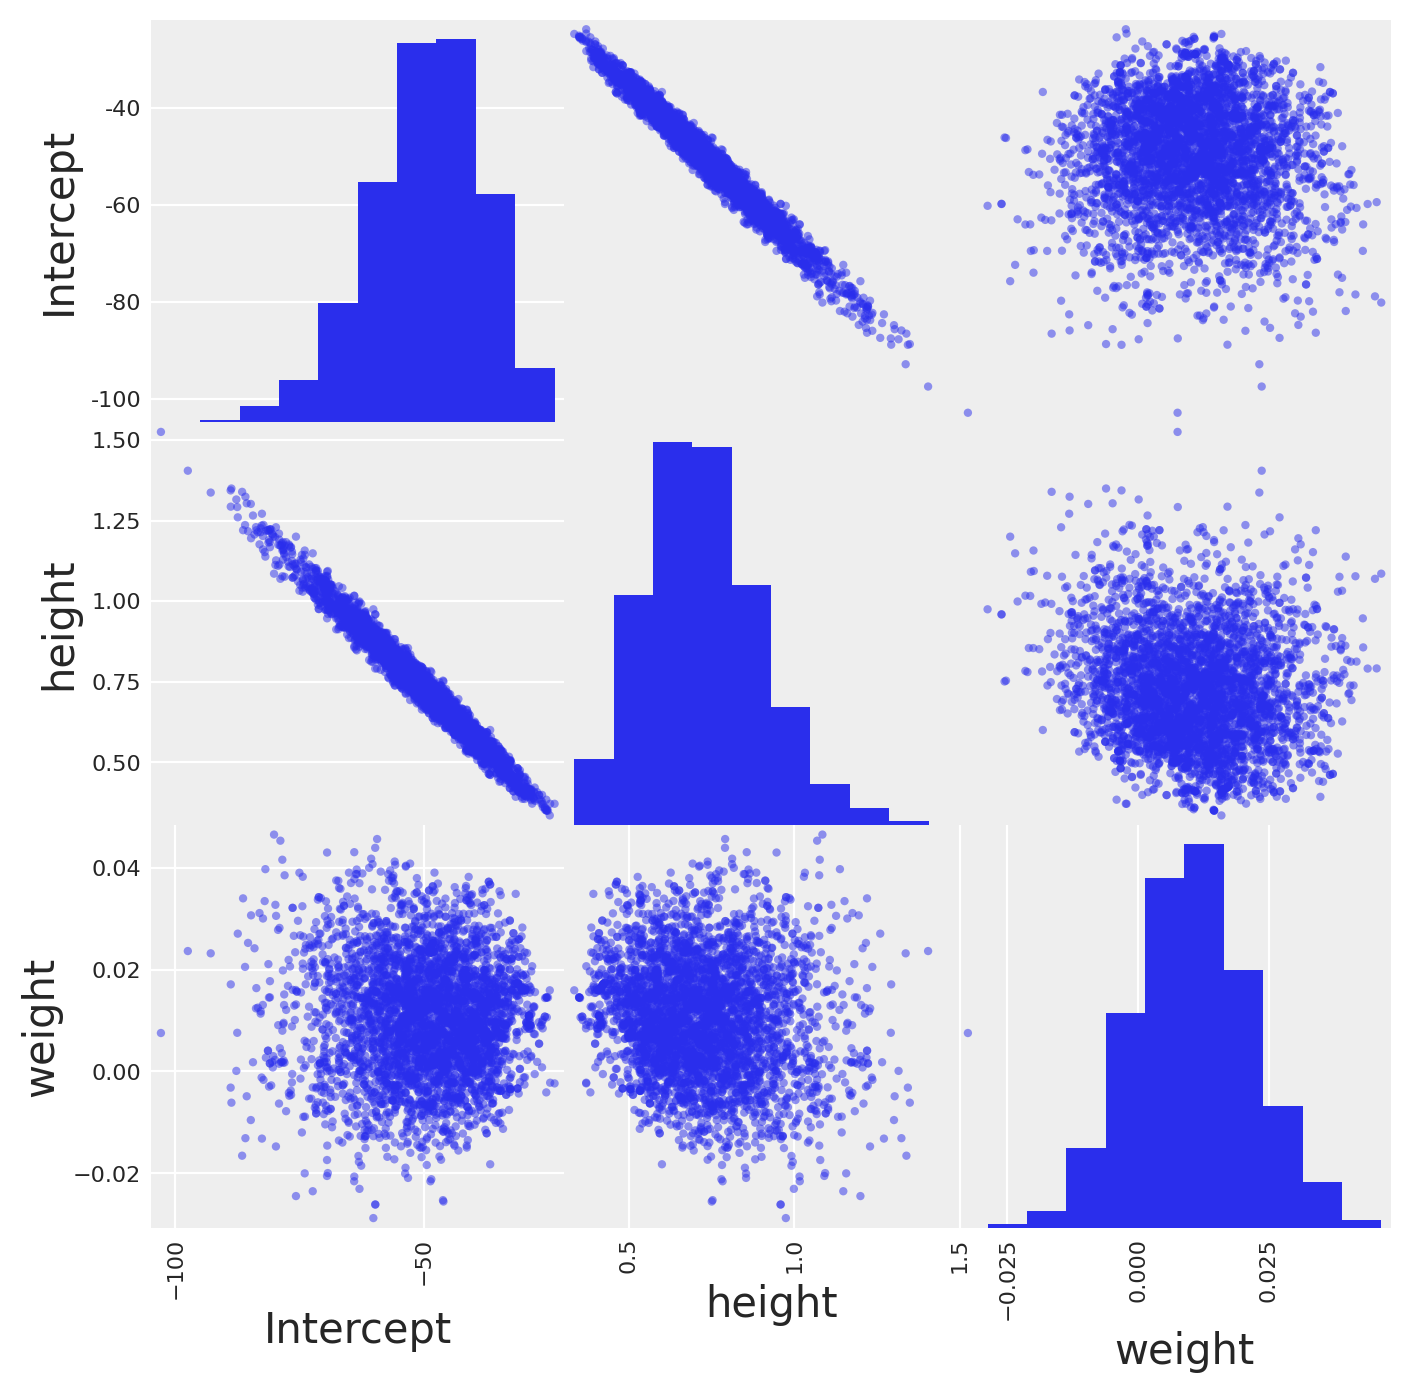

In [19]:
trace_df = trace_to_dataframe(trace_htwt)
print(trace_df.describe().drop("count").T)
scatter_matrix(trace_df, figsize=(8, 8))
print("P(weight < 0) = ", (trace_df["weight"] < 0).mean())
print("P(height < 0) = ", (trace_df["height"] < 0).mean())

## Bayesian Logistic Lasso

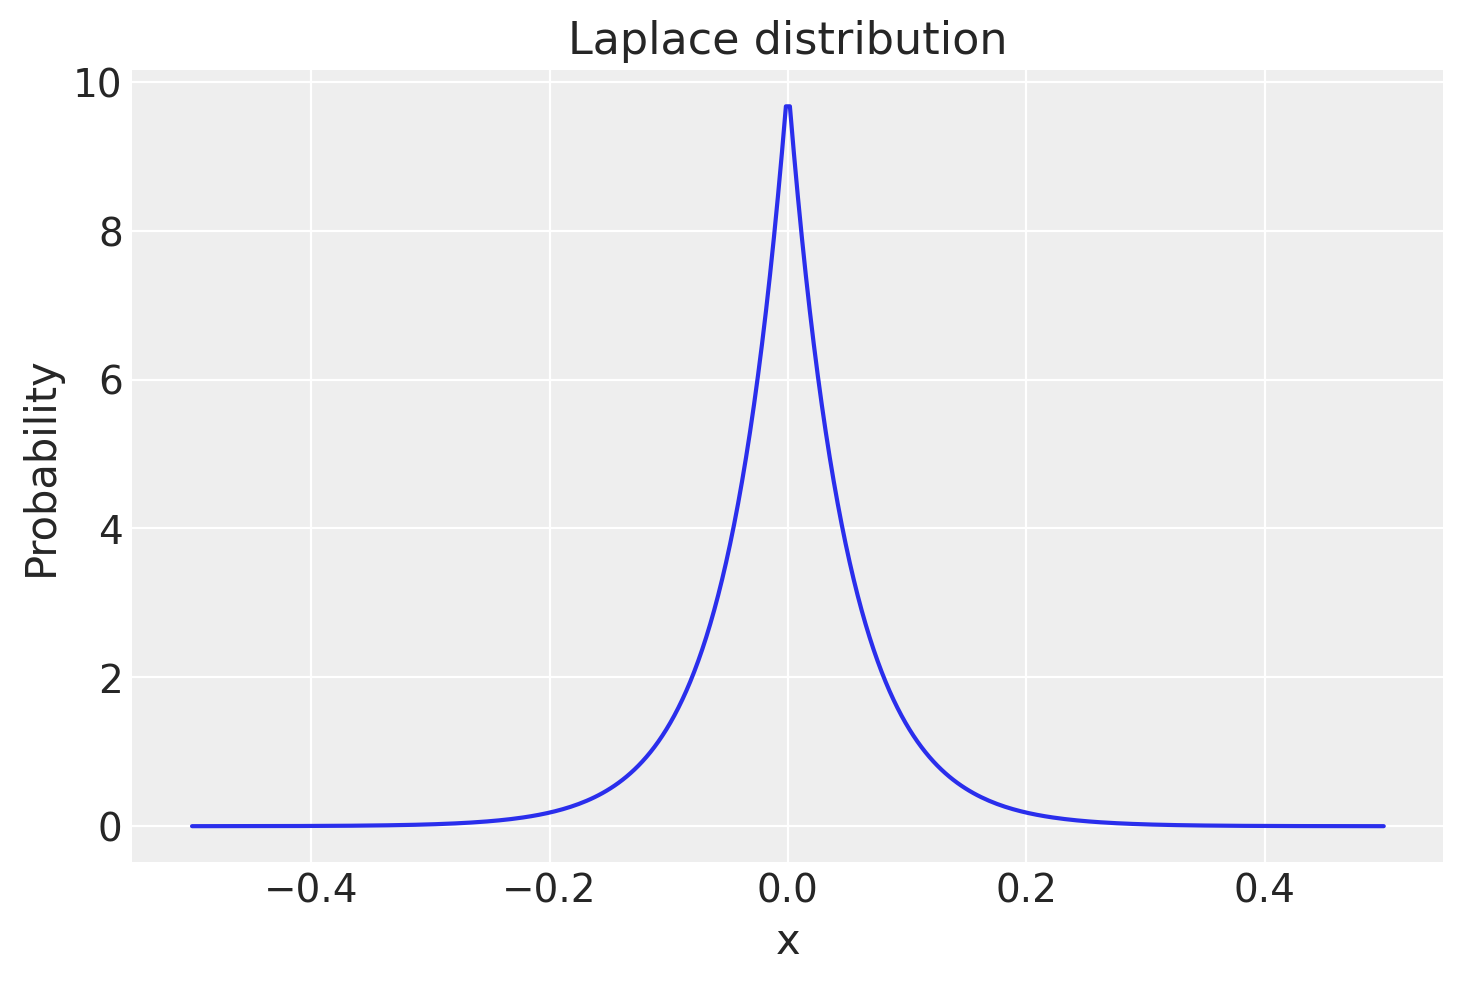

In [20]:
lp = Laplace.dist(mu=0, b=0.05)
x_eval = np.linspace(-0.5, 0.5, 300)
plt.plot(x_eval, theano.tensor.exp(lp.logp(x_eval)).eval())
plt.xlabel("x")
plt.ylabel("Probability")
plt.title("Laplace distribution");

In [ ]:
with Model() as model_lasso:
    # Define priors for intercept and regression coefficients.
    priors = {"Intercept": Normal.dist(mu=0, sigma=50), "Regressor": Laplace.dist(mu=0, b=0.05)}
    GLM.from_formula(
        "male ~ height + weight", htwt_data, family=glm.families.Binomial(), priors=priors
    )

    trace_lasso = sample(500, cores=2, init="adapt_diag")

trace_df = trace_to_dataframe(trace_lasso)
scatter_matrix(trace_df, figsize=(8, 8))
print(trace_df.describe().drop("count").T)

<ipython-input-21-5b24ecd4f87b>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_lasso = sample(500, cores=2, init="adapt_diag")
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [weight, height, Intercept]


In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w